# Introduction
This notebook is contains 5 main sections, each section can be run on its own without running the sections before. Within each section, the cells have to be run in sequence. Before that, the cell after this has to be run first.

*   Data Visualisation
*   Model - Training
*   Model - Testing
*   Display Results
*   Attacks





In [3]:
# MUST RUN THIS FIRST!!!

#---------- IMPORTS -----------#
# data analytics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# for image and dataset loading
from PIL import Image
from imageio import imread
from scipy import ndimage

# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

# misc
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import re
from datetime import datetime
from zipfile import ZipFile

# custom code
from utils.datasets import *
from utils.config import *
from utils.network import *
from utils.netMixin import *
from utils.attacks import *

# init the torch seeds
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(100)
torch.cuda.manual_seed(100)
np.random.seed(100)

#---------- preparing the data ----------#
# file dirs
data_filename = 'data/nyu_data.zip'
train_csv_filename = 'data/nyu2_train.csv'
test_csv_filename = 'data/nyu2_test.csv'

# extract filenames from zip file
zf = ZipFile(data_filename)
train_data = zf.read(train_csv_filename).decode("utf-8") 
train_data = np.array([line.split(',') for line in train_data.split()])

# define train validation set split ratio
train_val_test_ratio = [0.7, 0.1, 0.2]

# get (train, val, test) start and end indices
_, train_end, val_end = [sum(train_val_test_ratio[:n]) for n in range(len(train_val_test_ratio))]
train_end = val_start = floor(train_end * len(train_data))
val_end = test_start = floor(val_end * len(train_data))

# train_data contains paths to xs and ys, spliting it for train, val and test
train_xy = train_data[:train_end]
val_xy = train_data[val_start:val_end]
test_xy = train_data[test_start:]

# Data visualisation

In [4]:
#-------- init datasets ----------#
datasets = {
    'train': depth_est_dataset_v2(train_xy, zf),
    'val': depth_est_dataset_v2(val_xy, zf),
    'test': depth_est_dataset_v2(test_xy, zf)
}

@interact(name=['train', 'val', 'test'], index=(0, 100))
def see(name, index):
    ds = datasets[name]
    print('{} dataset has {} image-depthmap pairs.'.format(name, len(ds)))
    ds.show_images(index)

interactive(children=(Dropdown(description='name', options=('train', 'val', 'test'), value='train'), IntSlider…

# Model - Training

In [5]:
#-------- init model for training --------#
hidden_layers = 8
model = depth8(hidden_layers)

#--------- init dataloaders for training ----------#
datasets = {
    'train': depth_est_dataset_v2(train_xy, zf),
    'val': depth_est_dataset_v2(val_xy, zf),
    'test': depth_est_dataset_v2(test_xy, zf)
}
trainloader, validloader, _ = get_dataloaders(datasets, {'batch_size': 16})

#--------- set hyperparams --------------#
weight_decay = 1e-5
lr = 0.001
eps = 2
criterion = depthEstLoss()
optimizer = torch.optim.RMSprop(model.parameters(), weight_decay=weight_decay, lr=lr)

#-------- training loop ----------#
# Note:
# This training loop is just a sample to train your own model.
# Our model, models/Depth8.pt is trained with this function with 15 eps.

losses = model.train_model(
    trainloader,
    validloader,
    eps,
    optimizer,
    criterion,
    save_location='models/new_model.pt'
)

---------- Epoch 1 of 2 @ 02-05-2021 21:27:53 ----------



Average training loss: 1531.5917749937908



Average Validation Loss: 1528.708

---------- Epoch 2 of 2 @ 02-05-2021 22:17:22 ----------



Average training loss: 913.6786335998107



Average Validation Loss: 1471.614



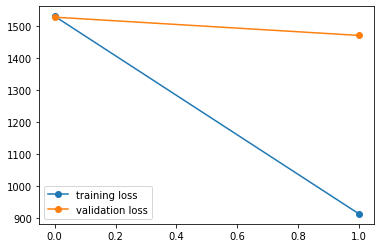

In [6]:
#-------- plot losses -----------#
eps = [x[0] for x in losses]
training_losses = [x[1] for x in losses]
validation_losses = [x[2] for x in losses]

plt.plot(eps, training_losses, '-o', label="training loss")
plt.plot(eps, validation_losses, '-o', label='validation loss')
plt.legend()
plt.show()

# Model - Testing

In [7]:
#--------- get trained model ----------#
trained_model = depth8(8)
trained_model.load_model('models/Depth8.pt') # change this to new model to find out how the new model does
criterion = depthEstLoss()

#--------- init dataloaders for testing ----------#
datasets = {
    'train': depth_est_dataset_v2(train_xy, zf),
    'val': depth_est_dataset_v2(val_xy, zf),
    'test': depth_est_dataset_v2(test_xy, zf)
}
_, _, testloader = get_dataloaders(datasets, {'batch_size': 16})

# Test the model and get results
advanced = True # get advanced metrics instead of just test loss
scores = trained_model.test_model(testloader, criterion, advanced=advanced)
metrics = ['Average Test loss', 'avg_d1', 'avg_d2', 'avg_d3', 'avg_rms_log', 'avg_abs_rel', 'avg_sq_rel', 'avg_rms_log10']
pd.DataFrame(data={'Metrics': metrics, 'Scores':scores})

Metrics      Scores
0  Average Test loss  980.025905
1             avg_d1    0.399267
2             avg_d2    0.693514
3             avg_d3    0.861370
4        avg_rms_log    0.435570
5        avg_abs_rel    0.379260
6         avg_sq_rel   13.717097
7      avg_rms_log10    0.189166

# Display Results

In [8]:
#--------- get trained model ----------#
trained_model = depth8(8)
trained_model.load_model('models/Depth8.pt') # change this to new model to find out how the new model does
criterion = depthEstLoss()

In [9]:
testset = depth_est_dataset_v2(test_xy, zf)
@interact(index=(0, len(testset)))
def see(index):
    x, y = testset[index]
    display_predictions(trained_model, x, y, criterion)

interactive(children=(IntSlider(value=5069, description='index', max=10138), Output()), _dom_classes=('widget-…

# Attacks

In [10]:
#--------- get trained model ----------#
trained_model = depth8(8)
trained_model.load_model('models/Depth8.pt') # change this to new model to find out how the new model does
criterion = depthEstLoss()

#------ init original dataset for comparison------#
datasets = {
    'train': depth_est_dataset_v2(train_xy, zf),
    'val': depth_est_dataset_v2(val_xy, zf),
    'test': depth_est_dataset_v2(test_xy, zf)
}
testset = datasets['test']

#--------- init fresh datasets to perform attack transformations ----------#
datasets_att = {
    'train': depth_est_dataset_v2(train_xy, zf),
    'val': depth_est_dataset_v2(val_xy, zf),
    'test': depth_est_dataset_v2(test_xy, zf)
}
testset_att = datasets_att['test']
_, _, testloader_att = get_dataloaders(datasets_att, {'batch_size': 16})

## Epsilon Noising

In [11]:
@interact(index=(0, len(testset_att)))
def see(index):
    testset_att.set_tx(transforms.Compose([
        transforms.ToTensor(),
        transform_enm_attack(1.0)
    ]))
    print('Showing input, prediction and truth for original and attacked samples\n')

    # display original results
    x, y = testset[index]
    display_predictions(trained_model, x, y, criterion)  

    # display attack results
    x_att, y_att = testset_att[index]
    display_predictions(trained_model, x_att, y_att, criterion) 

interactive(children=(IntSlider(value=5069, description='index', max=10138), Output()), _dom_classes=('widget-…

## Occlusion-based interpretability

### Sample 1 (Testset sample 24)

Showing input, prediction and truth for original and attacked samples

Loss value: 567.3114013671875
Loss value: 596.375


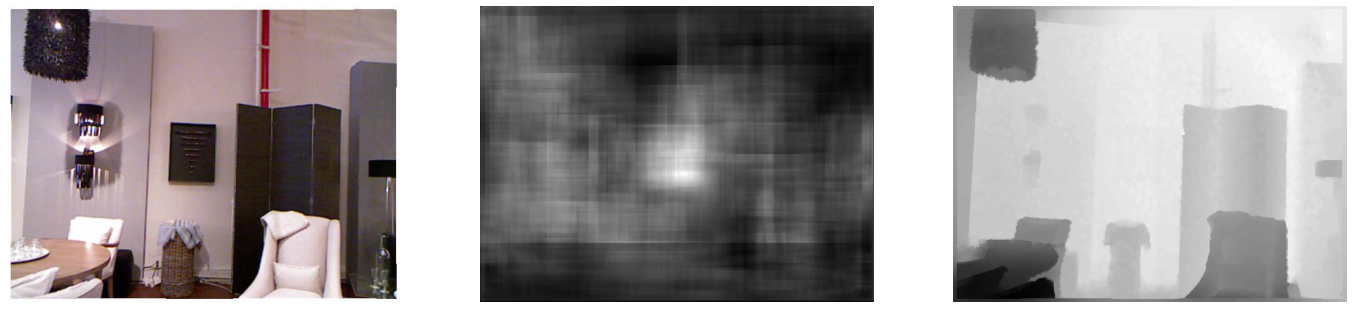

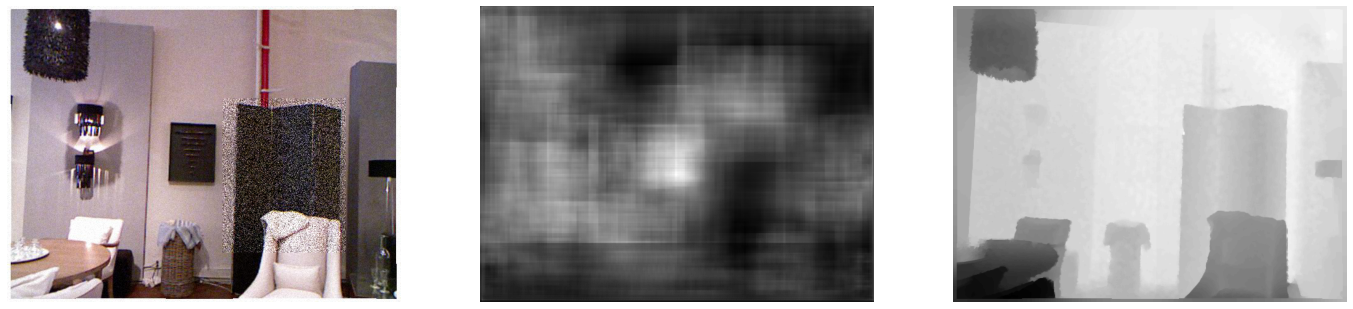

In [12]:
testset_att.set_tx(transforms.Compose([
    transforms.ToTensor(),
    targetted_object_noise_sample24(0.2)
]))

print('Showing input, prediction and truth for original and attacked samples\n')

x, y = testset[24]
x_att, y_att = testset_att[24]
display_predictions(trained_model, x, y, criterion)  
display_predictions(trained_model, x_att, y_att, criterion)  

### Sample 1 (Testset sample 30)

Showing input, prediction and truth for original and attacked samples

Loss value: 632.5960083007812
Loss value: 589.8291015625


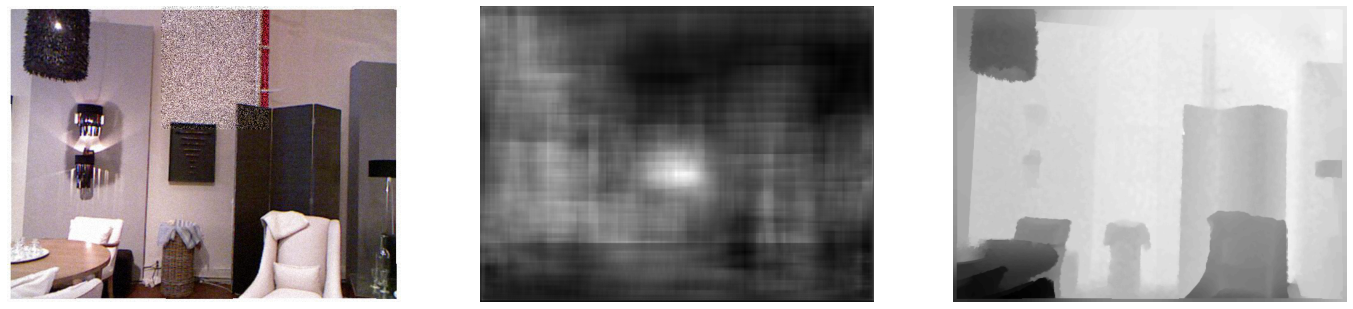

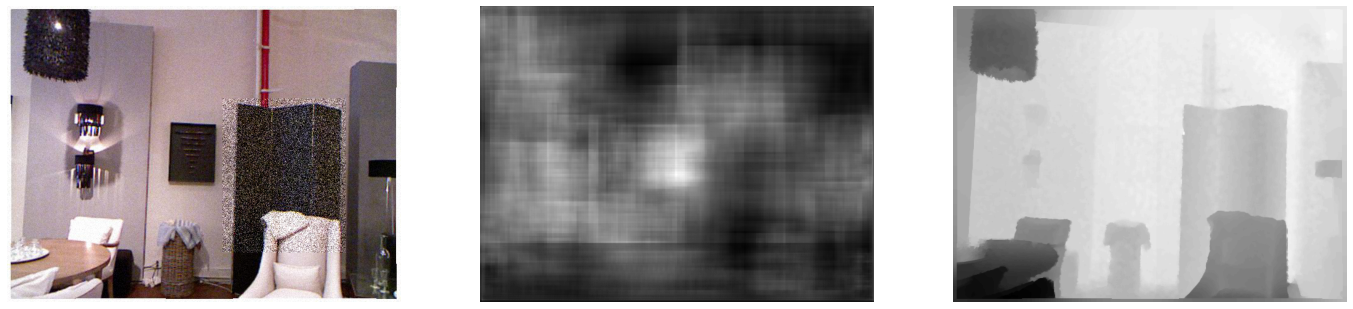

In [13]:
datasets['test'].set_tx(transforms.Compose([
    transforms.ToTensor(),
    targetted_object_noise_sample30(0.2)
]))

print('Showing input, prediction and truth for original and attacked samples\n')

x, y = testset[24]
x_att, y_att = testset_att[24]
display_predictions(trained_model, x, y, criterion)  
display_predictions(trained_model, x_att, y_att, criterion)   

## Fast Gradient Sign Method (FGSM)

In [14]:
# Note:
# For this cell, if you have ran other attack cells,
# re-run the cell. Otherwise, this cell will display 
# attack results of the previous attack that you ran.

testset_att.set_tx(transforms.Compose([
    transforms.ToTensor(),
    transform_fgsm_attack(trained_model, testloader, criterion, 0.25)
]))
@interact(index=(0, 15))
def see(index):
    print('Showing input, prediction and truth for original and attacked samples\n')
    # display original results
    x, y = testset[index]
    display_predictions(trained_model, x, y, criterion)  

    # display attack results
    x_att, y_att = testset_att[index]
    display_predictions(trained_model, x_att, y_att, criterion)  

interactive(children=(IntSlider(value=7, description='index', max=15), Output()), _dom_classes=('widget-intera…